In [1]:
# -- IMPORTS -- #
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input,decode_predictions
from tensorflow.python.ops import nn_ops, gen_nn_ops
from keras.models import Model
from keras.layers import Dense
import keras.preprocessing.image as kerasImage
import keras.backend as K
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import copy as cp
import os
import sys

Using TensorFlow backend.


In [2]:
# -- GLOBAL VALUES -- #
maxValue = 1e+7
minValue = -1e+7
#pred = np.array([range(1000)[::-1]])
#decoded = decode_predictions(pred,top=1000)
#result = [item[1] for item in decoded[0]]
#print(result)

In [3]:
# -- DEFINE FUNCTIONS -- #
def load_image(path,targetSize=(224,224),preprocess=True):
    data = kerasImage.load_img(path,target_size=targetSize)
    if preprocess:
        data = kerasImage.img_to_array(data)
        data = np.expand_dims(data,axis=0)
        #data = preprocess_input(data)
    return data

def reduce_channels(imgData,axis=-1,option='sum'):
    if option == 'sum':
        return imgData.sum(axis=axis)
    elif option == 'mean':
        return imgData.mean(axis=axis)
    else:
        assert False, 'This option is not supported'

def gamma_correction(image,gamma=0.4,minamp=0,maxamp=None):
    gamImg = np.zeros_like(image)
    image -= minamp
    if maxamp is None:
        maxamp = np.abs(image).max()+K.epsilon()
    image /= maxamp
    posMask = (image > 0)
    negMask = (image < 0)
    gamImg[posMask] = np.power(image[posMask], gamma)
    gamImg[negMask] = -np.power(-image[negMask], gamma)
    gamImg = gamImg * maxamp + minamp
    return gamImg

def visualize_heatmap(image,heatmap,cmap,savePath):
    fig = plt.figure(figsize=(6, 4))
    plt.subplot(121)
    plt.title('Original')
    plt.axis('off')
    plt.imshow(image)
    plt.subplot(122)
    plt.title('LRP')
    plt.axis('off')
    plt.imshow(heatmap[0],interpolation='bilinear',cmap=cmap)
    fig.savefig(savePath,dpi=250)

def deprocess_image(x):
    x -= x.mean(); x /= (x.std() + K.epsilon()); x *= 0.1
    # CLIP DATA
    x += 0.5; x = np.clip(x, 0, 1)
    # CONVERT TO RGB
    x *= 255; x = np.clip(x, 0, 255).astype('uint8')
    return x

def softmax2relu(model):
    weights = model.layers[-1].get_weights()
    model.layers.pop()
    model.layers[-1].outbound_nodes = []
    model.outputs = [model.layers[-1].output]
    output = Dense(1000,activation='relu',name='predictions')(model.outputs[0])
    reluModel = Model(inputs=model.inputs,outputs=[output])
    reluModel.layers[-1].set_weights(weights)
    return reluModel

def print_tensor_shape(tensor):
    shape = '('
    for s in range(len(tensor.shape)):
        shape += str(tensor.shape[s].value)+','
    return shape[0:-1]+')'

In [4]:
# -- Z RULE -- #
class ZRule(object):
    
    def __init__(self,currLayer,nextAct):
        self.layer = currLayer
        self.name = currLayer.name
        self.type = self.layer.__class__.__name__
        self.act = K.identity(nextAct)
        
    def run(self,R,ignoreBias=True):
        if self.type == 'Dense':
            return self.run_dense(R,ignoreBias)
        elif self.type == 'MaxPooling2D':
            return self.run_pool(R)
        elif self.type == 'Conv2D':
            return self.run_conv(R,ignoreBias)
        elif self.type == 'Flatten':
            return self.run_flatten(R)
        else:
            assert False, 'This layer is not supported'
    
    def run_dense(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        self.W = K.identity(weights[0])
        self.B = K.identity(weights[1])
        Z = K.dot(self.act,self.W)+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        C = K.dot(S,K.transpose(self.W))
        return K.clip(self.act*C,minValue,maxValue)
    
    def run_flatten(self,R):
        shape = self.act.get_shape().as_list()
        shape[0] = -1
        return K.reshape(R, shape)
    
    def run_pool(self,R):
        poolSize = (1,self.layer.pool_size[0],self.layer.pool_size[1],1)
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        Z = tf.nn.max_pool(self.act, 
                          ksize = poolSize, 
                          strides = strdSize, 
                          padding = self.layer.padding.upper())+K.epsilon()
        S = R/Z
        C = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Z, S, poolSize, strdSize,
                                        self.layer.padding.upper())
        return K.clip(self.act*C,minValue,maxValue)
    
    def run_conv(self,R,ignoreBias):
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        weights = self.layer.get_weights()
        self.W = K.identity(weights[0])
        self.B = K.identity(weights[1])
        Z = tf.nn.conv2d(self.act, 
                         self.W, 
                         strides = strdSize,
                         padding = self.layer.padding.upper())+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        C = nn_ops.conv2d_backprop_input(K.shape(self.act),
                                          self.W,
                                          S,strdSize,self.layer.padding.upper())
        return K.clip(self.act*C,minValue,maxValue)

In [5]:
# -- Z+ RULE -- #
class ZPlus(object):
    
    def __init__(self,currLayer,nextAct):
        self.layer = currLayer
        self.name = currLayer.name
        self.type = self.layer.__class__.__name__
        self.act = K.identity(nextAct)
        
    def run(self,R,ignoreBias=True):
        if self.type == 'Dense':
            return self.run_dense(R,ignoreBias)
        elif self.type == 'MaxPooling2D':
            return self.run_pool(R)
        elif self.type == 'Conv2D':
            return self.run_conv(R,ignoreBias)
        elif self.type == 'Flatten':
            return self.run_flatten(R)
        else:
            assert False, 'This layer is not supported'
            
    def run_dense(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        self.W = K.maximum(weights[0],0.)
        self.B = K.maximum(weights[1],0.)
        Z = K.dot(self.act,self.W)+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        C = K.dot(S,K.transpose(self.W))
        return K.clip(self.act*C,minValue,maxValue)
    
    def run_flatten(self,R):
        shape = self.act.get_shape().as_list()
        shape[0] = -1
        return K.reshape(R, shape)
    
    def run_pool(self,R):
        poolSize = (1,self.layer.pool_size[0],self.layer.pool_size[1],1)
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        pooled = tf.nn.max_pool(self.act, 
                          ksize = poolSize, 
                          strides = strdSize, 
                          padding = self.layer.padding.upper())
        Z = K.maximum(pooled,0.)+K.epsilon()
        S = R/Z
        C = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Z, S, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        return K.clip(self.act*C,minValue,maxValue)
    
    def run_conv(self,R,ignoreBias):
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        weights = self.layer.get_weights()
        self.W = K.maximum(weights[0],0.)
        self.B = K.maximum(weights[1],0.)
        Z = tf.nn.conv2d(self.act, 
                         self.W, 
                         strides = strdSize,
                         padding = self.layer.padding.upper())+K.epsilon()
        if not ignoreBias:
            Z += self.B
        S = R/Z
        C = nn_ops.conv2d_backprop_input(K.shape(self.act),
                                          self.W,
                                          S,strdSize,self.layer.padding.upper())
        return K.clip(self.act*C,minValue,maxValue)

In [4]:
# -- ZAlpha RULE -- #
class ZAlpha(object):
    
    def __init__(self,currLayer,nextAct,alpha):
        self.alpha = alpha
        self.beta = 1-alpha
        self.layer = currLayer
        self.name = currLayer.name
        self.type = self.layer.__class__.__name__
        self.act = K.identity(nextAct)
        
    def run(self,R,ignoreBias=True):
        if self.type == 'Dense':
            return self.run_dense(R,ignoreBias)
        elif self.type == 'MaxPooling2D':
            return self.run_pool(R)
        elif self.type == 'Conv2D':
            return self.run_conv(R,ignoreBias)
        elif self.type == 'Flatten':
            return self.run_flatten(R)
        else:
            assert False, 'This layer is not supported'
        
    def run_dense(self,R,ignoreBias=True):
        weights = self.layer.get_weights()
        self.maxW = K.maximum(weights[0],0.); self.maxB = K.maximum(weights[1],0.)
        self.minW = K.minimum(weights[0],0.); self.minB = K.minimum(weights[1],0.)   
        Za = K.dot(self.act,self.maxW)+K.epsilon(); Zb = K.dot(self.act,self.minW)-K.epsilon()
        if not ignoreBias:
            Za += self.maxB; Zb += self.minB
        Sa = R/Za; Sb = R/Zb
        Ca = K.dot(Sa,K.transpose(self.maxW)); Cb = K.dot(Sb,K.transpose(self.minW))
        Rn = self.act*(self.alpha*Ca+self.beta*Cb)
        return K.clip(Rn,minValue,maxValue)
        
    def run_flatten(self,R):
        shape = self.act.get_shape().as_list()
        shape[0] = -1
        return K.reshape(R, shape)
    
    def run_pool(self,R):
        poolSize = (1,self.layer.pool_size[0],self.layer.pool_size[1],1)
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        pooled = tf.nn.max_pool(self.act, 
                          ksize = poolSize, 
                          strides = strdSize, 
                          padding = self.layer.padding.upper())
        Za = K.maximum(pooled,0.)+K.epsilon(); Zb = K.minimum(pooled,0.)-K.epsilon()
        Sa = R/Za; Sb = R/Zb
        Ca = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Za, Sa, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        Cb = gen_nn_ops.max_pool_grad_v2(self.act,
                                        Zb, Sb, poolSize, strdSize,
                                        padding = self.layer.padding.upper())
        Rn = self.act*(self.alpha*Ca+self.beta*Cb)
        return K.clip(Rn,minValue,maxValue)
    
    def run_conv(self,R,ignoreBias=True):
        strdSize = (1,self.layer.strides[0],self.layer.strides[1],1)
        weights = self.layer.get_weights()
        self.maxW = K.maximum(weights[0],0.); self.maxB = K.maximum(weights[1],0.)
        self.minW = K.minimum(weights[0],0.); self.minB = K.minimum(weights[1],0.)
        Za = tf.nn.conv2d(self.act, 
                          self.maxW, 
                          strides = strdSize,
                          padding = self.layer.padding.upper())+K.epsilon()
        Zb = tf.nn.conv2d(self.act, 
                          self.minW, 
                          strides = strdSize,
                          padding = self.layer.padding.upper())-K.epsilon()
        if not ignoreBias:
            Za += self.maxB; Zb += self.minB
        Sa = R/Za; Sb = R/Zb
        Ca = nn_ops.conv2d_backprop_input(K.shape(self.act),
                                          self.maxW,
                                          Sa,strdSize,self.layer.padding.upper())
        Cb = nn_ops.conv2d_backprop_input(K.shape(self.act),
                                          self.minW,
                                          Sb,strdSize,self.layer.padding.upper())
        Rn = self.act*(self.alpha*Ca+self.beta*Cb)
        return K.clip(Rn,minValue,maxValue)

In [5]:
# -- DEFINE LRP MODEL -- #
class LRPModel():
    def __init__(self,model,rule=True,verbose=True):
        # -- MODIFY MODEL -- #
        print('\nLRPModel Initialization...')
        print('--------------------------')
        reluModel = softmax2relu(model)
        activations = []
        for layer in reluModel.layers[1:]:
            activations.append(layer.output)
        self.model = Model(inputs=reluModel.input,outputs=activations)
        if verbose:
            self.model.summary()
        if rule:
            print('Select the desired Rule to execute LRP:')
            self.optionRule = input('(ZRule)-(ZPlus)-(ZAlpha): ')
        else:
            self.optionRule = 'ZRule'
        if self.optionRule == 'ZAlpha':
            self.alpha = int(input('Select a Value for Alpha: '))
            assert self.alpha >= 1
        self.R = 0; self.outputR = 0; self.rules = 0
        self.numLayers = len(self.model.layers)
        print('========== DONE ==========\n')
    
    def visualize_relevance(self,rawData,savePath,cmap='bwr',option='sum'):
        print('Visualize LRP Result...')
        print('--------------------------')
        with tf.Session():
            relevance = self.R['input'].eval()
            print('Evaluation executed.')
        print('Creating Heatmap')
        oneDim = reduce_channels(relevance.copy(),option=option)
        heatMap = deprocess_image(oneDim.copy())
        visualize_heatmap(rawData,heatMap,cmap,savePath)
        print('========== DONE ==========\n')
    
    def eval_relevance(self,layer):
        print('Evaluate tensor...')
        print('--------------------------') 
        with tf.Session():
            relevance = self.R[layer].eval()
        print('========== DONE ==========\n')
        return relevance
            
    def define_rules(self,imgData,oneHot=False,verbose=True):
        # -- DEFINE RULES -- #
        print('Define Rules...')
        print('--------------------------')       
        layerRules = []; self.outputR = self.model.predict(imgData)
        if oneHot:
            neuron = np.argmax(self.outputR[-1]); maxAct = self.outputR[-1][:,neuron]
            self.outputR[-1] = np.zeros(self.outputR[-1].shape,dtype='float32')
            self.outputR[-1][:,neuron] = maxAct
        for currLayer,k in zip(reversed(self.model.layers),range(self.numLayers-2,-1,-1)):
            nextLayer = currLayer._inbound_nodes[0].inbound_layers[0]
            activation = self.outputR[k-1] if (k-1!=-1) else imgData
            if self.optionRule == 'ZRule':
                layerRules.append(ZRule(currLayer,activation))
            elif self.optionRule == 'ZPlus':
                layerRules.append(ZPlus(currLayer,activation))
            elif self.optionRule == 'ZAlpha':
                layerRules.append(ZAlpha(currLayer,activation,self.alpha))
            else:
                assert False, 'This Rule Option is not supported'
            if verbose:
                print('<><><><><>')
                print('Weights From: ['+currLayer.name+']')
                print('Activations From: ['+nextLayer.name+']')
        self.rules = layerRules
        print('========== DONE ==========\n')
        
    def run_rules(self,verbose=True):
        # -- RUN RULES -- #
        print('Run Rules...')
        print('--------------------------')
        R = {};
        R[self.rules[0].name] = K.identity(self.outputR[-1])
        if verbose:
            shape = print_tensor_shape(R[self.rules[0].name])
            print('<><><><><>')
            print('Rule R['+self.rules[0].name+'] Correctly runned.')
            print('Tensor Output Shape: '+shape)
        for k in range(len(self.rules)):
            if k != len(self.rules)-1:
                R[self.rules[k+1].name] = self.rules[k].run(R[self.rules[k].name],ignoreBias=False)
                if verbose:
                    shape = print_tensor_shape(R[self.rules[k+1].name])
                    print('<><><><><>')
                    print('Rule R['+self.rules[k+1].name+'] Correctly runned.')
                    print('Tensor Output Shape: '+shape)
            else:
                R['input'] = self.rules[k].run(R[self.rules[k].name],ignoreBias=False)
                if verbose:
                    shape = print_tensor_shape(R['input'])
                    print('<><><><><>')
                    print('Rule R[input] Correctly runned.')
                    print('Tensor Output Shape: '+shape)
        print('========== DONE ==========\n')
        self.R = R

In [6]:
# -- GET IMAGE -- #
imgSel = input('Select the image: ')
fileName = './Data/images/'+imgSel+'.jpg'
imgData = load_image(fileName)
rawData = load_image(fileName,preprocess=False)

Select the image:  test_5


In [ ]:
with K.get_session() as sess:
    K.set_session(sess)
    # -- LOAD MODEL -- #
    model = VGG16(weights='imagenet',include_top=True)
    # -- REPRESENT HEATMAP -- #
    LRP = LRPModel(model,verbose=False)
    LRP.define_rules(imgData,oneHot=False,verbose=False)
    LRP.run_rules(verbose=True)
    relevance = sess.run(LRP.R['input'])
print('========== DONE ==========\n')

Instructions for updating:
Colocations handled automatically by placer.

LRPModel Initialization...
--------------------------
Select the desired Rule to execute LRP:


(ZRule)-(ZPlus)-(ZAlpha):  ZAlpha
Select a Value for Alpha:  1


========== DONE ==========

Define Rules...
--------------------------
========== DONE ==========

Run Rules...
--------------------------
<><><><><>
Rule R[predictions] Correctly runned.
Tensor Output Shape: (1,1000)
<><><><><>
Rule R[fc2] Correctly runned.
Tensor Output Shape: (1,4096)
<><><><><>
Rule R[fc1] Correctly runned.
Tensor Output Shape: (1,4096)
<><><><><>
Rule R[flatten] Correctly runned.
Tensor Output Shape: (1,25088)
<><><><><>
Rule R[block5_pool] Correctly runned.
Tensor Output Shape: (1,7,7,512)
<><><><><>
Rule R[block5_conv3] Correctly runned.
Tensor Output Shape: (1,14,14,512)


In [8]:
savePath = './Results/LRP/'+LRP.optionRule+'_'+imgSel+'.png'
print(savePath)

./Results/LRP/ZAlpha_test_56.png


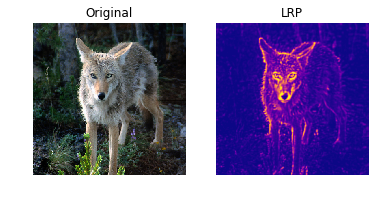

In [9]:
oneDim = reduce_channels(relevance.copy(),option='sum')
heatMap = deprocess_image(oneDim.copy())
# -- VISUALIZE -- #
visualize_heatmap(rawData,heatMap,'plasma',savePath)

In [12]:
print(np.max(heatMap),np.min(heatMap))

255 109
